In [1]:
import numpy as np
import scipy as sc
import scipy
import scipy.optimize as opt
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.random import randint
import math
from scipy.optimize import minimize as mini
from scipy.optimize import least_squares as ls
from scipy.optimize import leastsq
import gc
from multiprocessing import Process

In [2]:
def lognormDT(x,mu,sigma,A_T):
    '''Defines the transfer function for the DT'''
    sigma = float(sigma)
    mu = float(mu)
    x = x #float(x)
    A_T = float(A_T)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = A_T/(x*sigma*np.sqrt(2*np.pi))
    return front*np.exp(exp)

In [3]:
#Define simple planck function (needs to be log?)
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

In [4]:
def lognormAD(x,mu,sigma,A_T,N_AD,T,ld):
    '''Defines the transfer function for the AD'''
    sigma = float(sigma)
    mu = float(mu)
    x = x #float(x)
    A_T = float(A_T)
    N_AD = float(N_AD)
    T = float(T)
    ld = float(ld)
    BB = planck(ld, T)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = (1-A_T)*N_AD/(x*sigma*np.sqrt(2*np.pi))
    return BB*front*np.exp(exp)

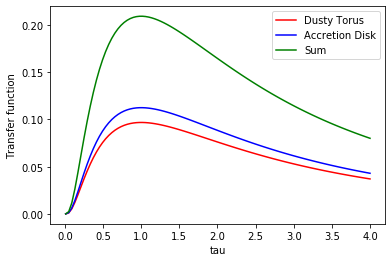

In [6]:
#define some data and parameters and plot the transfer functions 
tau=np.linspace(0.01,4,100)
sigma_DT=1
sigma_AD=1
mu_DT=1
mu_AD=1
A_T=0.4
N_AD=1
T=1500
ld=0.002

res1=lognormDT(tau,mu_DT,sigma_DT,A_T)
res2=lognormAD(tau,mu_AD,sigma_AD,A_T,N_AD,T,ld)
ressum=res1+res2

plt.plot(tau,res1,'r',label="Dusty Torus")
plt.plot(tau,res2,'b',label="Accretion Disk")
plt.plot(tau,ressum,'g',label="Sum")
plt.xlabel("tau")
plt.ylabel("Transfer function")
plt.legend()
plt.show()

In [7]:
# Define the exponentiated quadratic kernel
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [8]:
# Sample from the Gaussian process distribution
t=10#np.linspace(10,20,100) #A given time in our light curve
nb_of_samples = 100  # Number of points in each function
number_of_functions = 1  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(t-tau, 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

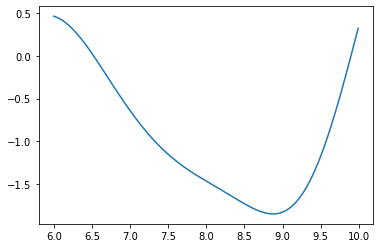

In [9]:
 plt.plot(t-tau,ys[0,:])

<function matplotlib.pyplot.show(*args, **kw)>

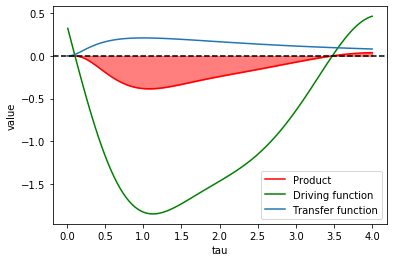

In [10]:
product = res1*ys + res2*ys #product needed to deconvolve. 
#Marked area under the product is what is hard to integrate so we need MCMC. 
plt.plot(tau,product[0,:],'r',label="Product")
plt.fill_between(tau,product[0,:],color='r',alpha=0.5)
plt.plot(tau,ys[0,:],'g',label="Driving function")
plt.plot(tau,ressum,label="Transfer function")
plt.legend()
plt.xlabel("tau")
plt.ylabel("value")
plt.axhline(y=0., color='k', linestyle='--')
plt.show